In [1]:
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
lemmatizer = WordNetLemmatizer()

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
# Neural Network lib
from tensorflow.keras.layers import Dense, Embedding, Dropout, GlobalAveragePooling1D
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import Dropout ,Conv1D,GlobalMaxPooling1D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import tensorflow.keras as keras
import pickle

In [2]:
df = pd.read_csv("IMDB Dataset.csv")

In [3]:
def styled_heading(text, background_color='#0077b6', text_color='white'):
    return f"""
    <p style="
        background-color: {background_color};
        font-family: Arial, sans-serif;
        font-size: 20px;
        font-weight: bold;
        color: {text_color};
        text-align: center;
        border-radius: 8px;
        padding: 12px;
        box-shadow: 2px 2px 5px rgba(0, 0, 0, 0.2);
        width: fit-content;
        margin: 10px auto;
    ">
        {text}
    </p>
    """
def style_table(df):
    return df.style.set_table_styles([
        {"selector": "th", "props": [("color", "white"), ("background-color", "#0077b6"), ("padding", "10px")]},
        {"selector": "td", "props": [("text-align", "center"), ("padding", "8px")]} 
    ]).set_properties(**{"border": "1px solid #ddd"}).hide(axis="index").to_html()

def print_dataset_analysis(df, n_top=5, heading_color='#0077b6', text_color='white'):
    display(HTML(styled_heading("📊 Basic Overview of Data", heading_color, text_color)))
    display(HTML(style_table(df.head(n_top))))
    
    display(HTML(styled_heading("🚫 Missing Values", heading_color, text_color)))
    null_counts = df.isnull().sum()
    if null_counts.sum() == 0:
        display(HTML("<p style='text-align:center; font-weight:bold;'>✅ No missing values in the dataset.</p>"))
    else:
        display(HTML(style_table(null_counts[null_counts > 0].to_frame(name='Missing Count'))))
    
    display(HTML(styled_heading("♻️ Duplicate Records", heading_color, text_color)))
    duplicates = df.duplicated().sum()
    display(HTML(f"<p style='text-align:center; font-weight:bold;'>🔄 {duplicates} duplicate rows found.</p>"))
    
    display(HTML(styled_heading("📏 Dataset Shape", heading_color, text_color)))
    display(HTML(f"<p style='text-align:center; font-weight:bold;'>Rows: {df.shape[0]}, Columns: {df.shape[1]}</p>"))

def print_value_counts(df, target_column, heading_color='#0077b6', text_color='white'):
    display(HTML(styled_heading("🔢 Value Counts", heading_color, text_color)))
    if target_column in df.columns:
        value_counts = df[target_column].value_counts()
        formatted_counts = "".join(f"<p style='text-align:center; font-weight:bold;'>{index}: {count}</p>" for index, count in value_counts.items())
        display(HTML(formatted_counts))
    else:
        display(HTML(f"<p style='text-align:center; font-weight:bold; color:red;'>⚠️ Column '{target_column}' not found in dataset.</p>"))

print_dataset_analysis(df,n_top=5)
print_value_counts(df,'sentiment')

review,sentiment
"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side.",positive
"A wonderful little production. The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.",positive
"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.This was the most I'd laughed at one of Woody's comedies in years (dare I say a decade?). While I've never been impressed with Scarlet Johanson, in this she managed to tone down her ""sexy"" image and jumped right into a average, but spirited young woman.This may not be the crown jewel of his career, but it was wittier than ""Devil Wears Prada"" and more interesting than ""Superman"" a great comedy to go see with friends.",positive
"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the mo

In [4]:
df=df.drop_duplicates()

In [5]:
# stop words to be removed later
custom_stopwords = set(stopwords.words('english'))  
# Make sure 'review' is a valid column name
print(df.columns)

Index(['review', 'sentiment'], dtype='object')


In [6]:
def preprocess_text(text):
    if isinstance(text, str):  # Ensure text is a string
        ## REMOVE HTML
        if "<" in text and ">" in text:
            text = BeautifulSoup(text, "html.parser").get_text()
        ## CLEANING
        # Remove special characters
        text = re.sub(r'\W+', ' ', text)  
        # Remove digits
        text = re.sub(r'\d+', '', text)
        ## LOWERCASING
        text = text.lower()
        ## TOKENIZATION
        words = text.split()
        ## REMOVE STOPWORDS
        words = [w for w in words if w not in custom_stopwords] 
        ## APPLY LEMMATIZATION
        words = [lemmatizer.lemmatize(w) for w in words]
        ## RETURN CLEANED TEXT
        return ' '.join(words)
    return ""
# Apply preprocessing
df['processed_review'] = df['review'].apply(preprocess_text)
# Show original vs processed text
print(df[['review', 'processed_review']].head(10))  

                                              review  \
0  One of the other reviewers has mentioned that ...   
1  A wonderful little production. <br /><br />The...   
2  I thought this was a wonderful way to spend ti...   
3  Basically there's a family where a little boy ...   
4  Petter Mattei's "Love in the Time of Money" is...   
5  Probably my all-time favorite movie, a story o...   
6  I sure would like to see a resurrection of a u...   
7  This show was an amazing, fresh & innovative i...   
8  Encouraged by the positive comments about this...   
9  If you like original gut wrenching laughter yo...   

                                    processed_review  
0  one reviewer mentioned watching oz episode hoo...  
1  wonderful little production filming technique ...  
2  thought wonderful way spend time hot summer we...  
3  basically family little boy jake think zombie ...  
4  petter mattei love time money visually stunnin...  
5  probably time favorite movie story selflessnes... 

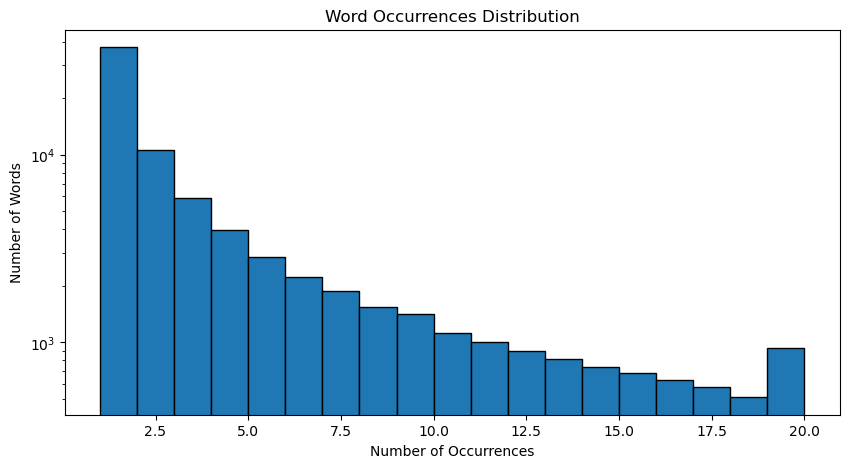

In [7]:
# BAG OF WORDS ASSUMPTION
word_counts = Counter(" ".join(df["processed_review"]).split())
# Get word frequencies
occurrences_values = list(word_counts.values())

# Plot histogram to help decide the threshold that will be used to remove rare words later
# threshold here is the minimum number of occurrences for one word so that it will not be considered as a rare word
plt.figure(figsize=(10, 5))
plt.hist(occurrences_values, bins=range(1, 21), edgecolor='black')  # Only show words appearing ≤ 20 times 
plt.yscale('log')  # Log scale helps visualize better
plt.xlabel("Number of Occurrences")
plt.ylabel("Number of Words")
plt.title("Word Occurrences Distribution")
plt.show()

In [8]:
## REMOVE RARE WORDS
# Most words appear very few times (1-5 occurrences)
# The count drops significantly as frequency increases  
# we will take a threshold of 4 which Keeps moderately rare words that might still carry meaning but Removes very infrequent words that could add noise

threshold = 4
# Identify rare words
rare_words = {w for w, c in word_counts.items() if c <= threshold}  

def remove_rare_words(text):
    if isinstance(text, str):  # Ensure text is a string
        words = text.split()
        return ' '.join([w for w in words if w not in rare_words])
    return ""

# Apply to dataset
df['processed_review2'] = df['processed_review'].apply(remove_rare_words)

# Check results
print(df[['processed_review', 'processed_review2']].head(10))

                                    processed_review  \
0  one reviewer mentioned watching oz episode hoo...   
1  wonderful little production filming technique ...   
2  thought wonderful way spend time hot summer we...   
3  basically family little boy jake think zombie ...   
4  petter mattei love time money visually stunnin...   
5  probably time favorite movie story selflessnes...   
6  sure would like see resurrection dated seahunt...   
7  show amazing fresh innovative idea first aired...   
8  encouraged positive comment film looking forwa...   
9  like original gut wrenching laughter like movi...   

                                   processed_review2  
0  one reviewer mentioned watching oz episode hoo...  
1  wonderful little production filming technique ...  
2  thought wonderful way spend time hot summer we...  
3  basically family little boy jake think zombie ...  
4  mattei love time money visually stunning film ...  
5  probably time favorite movie story sacrifice d... 

In [9]:
df.loc[df['sentiment'] == 'positive', 'sentiment'] = 1
df.loc[df['sentiment'] == 'negative', 'sentiment'] = 0
df.head()

,review,sentiment,processed_review,processed_review2
0,One of the other reviewers has mentioned that ...,1,one reviewer mentioned watching oz episode hoo...,one reviewer mentioned watching oz episode hoo...
1,A wonderful little production. <br /><br />The...,1,wonderful little production filming technique ...,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,1,thought wonderful way spend time hot summer we...,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,0,basically family little boy jake think zombie ...,basically family little boy jake think zombie ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,petter mattei love time money visually stunnin...,mattei love time money visually stunning film ...


In [10]:
X = df['processed_review2']  
y = df['sentiment']

In [11]:
y = np.array(y, dtype=np.int32)
label = np.eye(2, dtype=np.float32)[y]
label[0]

array([0., 1.], dtype=float32)

In [12]:
tokenize = Tokenizer()
tokenize.fit_on_texts(X)

with open("tokenizer.pkl", "wb") as handle:
    pickle.dump(tokenize, handle, protocol=pickle.HIGHEST_PROTOCOL)

token_sequance = tokenize.texts_to_sequences(X)
max_sentince_size = max(len(i) for i in token_sequance)
pad_data = pad_sequences(token_sequance, maxlen=max_sentince_size, padding='pre')

print('The max sentence size is:', max_sentince_size)
print('The shape of padding data:', pad_data.shape)

The max sentence size is: 1360
The shape of padding data: (49582, 1360)


In [13]:
voc_size = len(tokenize.word_index) + 1
print('Max vocab size : ', voc_size)

Max vocab size :  34656


In [14]:
X_train, X_test, y_train, y_test = train_test_split(pad_data, label, test_size=0.2, random_state=42)

print("Training set size:", len(X_train))
print("Testing set size:", len(X_test))

Training set size: 39665
Testing set size: 9917


In [15]:
model = keras.models.Sequential([
    Embedding(input_dim=voc_size, output_dim=max_sentince_size, input_length=max_sentince_size, mask_zero=True),
    SpatialDropout1D(0.3),
    GlobalAveragePooling1D(),
    Dropout(0.5),
    Dense(2, activation="softmax", kernel_regularizer=l2(0.001))
])

model.build(input_shape=(None, max_sentince_size))
model.compile(optimizer=Adam(learning_rate=0.0005), loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

C:\Users\abdo\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 1360, 1360)     │    47,132,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 1360, 1360)     │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 1360)           │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1360)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         2,722 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,134,882 (179.81 MB)

 Trainable params: 47,134,882 (179.81 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
early_stop = EarlyStopping(monitor='val_loss', patience=2)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=1, min_lr=0.00001)
checkpoint = ModelCheckpoint("best_model.keras", monitor="val_accuracy", save_best_only=True, mode="max", verbose=0)

In [17]:
history = model.fit(X_train, y_train, callbacks=[early_stop,reduce_lr,checkpoint], epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 1713s 1s/step - accuracy: 0.8257 - loss: 0.4924 - val_accuracy: 0.8909 - val_loss: 0.3200 - learning_rate: 5.0000e-04
Epoch 2/20
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 1743s 1s/step - accuracy: 0.9188 - loss: 0.2709 - val_accuracy: 0.9006 - val_loss: 0.2994 - learning_rate: 5.0000e-04
Epoch 3/20
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 1777s 1s/step - accuracy: 0.9398 - loss: 0.2281 - val_accuracy: 0.9005 - val_loss: 0.2931 - learning_rate: 5.0000e-04
Epoch 4/20
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 1730s 1s/step - accuracy: 0.9470 - loss: 0.2043 - val_accuracy: 0.9012 - val_loss: 0.2912 - learning_rate: 5.0000e-04
Epoch 5/20
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 1759s 1s/step - accuracy: 0.9565 - loss: 0.1831 - val_accuracy: 0.9001 - val_loss: 0.2916 - learning_rate: 5.0000e-04
Epoch 6/20
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 1688s 1s/step - accuracy: 0.9647 - loss: 0.1661 - val_accuracy: 0.9009 - val_loss: 0.2941 - learning_rate: 1.5000e-04


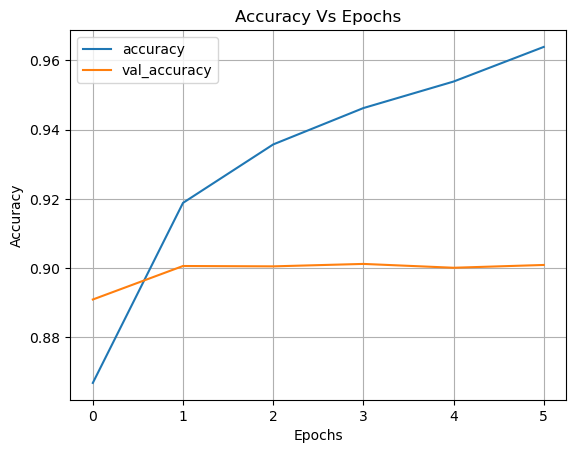

In [18]:
plt.plot(history.history["accuracy"] , label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.title("Accuracy Vs Epochs")

plt.legend()
plt.grid()

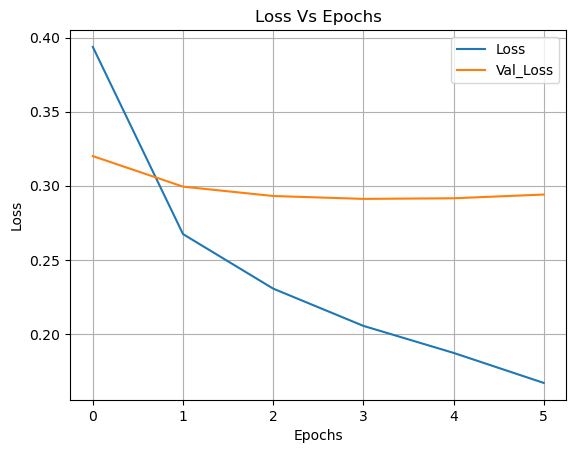

In [19]:
plt.plot(history.history["loss"], label="Loss")
plt.plot(history.history["val_loss"], label="Val_Loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.title("Loss Vs Epochs")

plt.legend()
plt.grid()

In [20]:
from tensorflow.keras.models import load_model

best_model = load_model("best_model.keras")
best_model.evaluate(X_test, y_test)

310/310 ━━━━━━━━━━━━━━━━━━━━ 55s 174ms/step - accuracy: 0.9010 - loss: 0.2910


[0.2911554276943207, 0.9011797904968262]